In [ ]:
import numpy as np
from google.colab import files
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
uploaded = files.upload()

Saving train_1.zip to train_1.zip
Saving val_1.zip to val_1.zip


In [ ]:
file1='/content/train_1.zip'
file2='/content/val_1.zip'
with ZipFile(file1,'r') as zip_ref:
  zip_ref.extractall('train_1')
with ZipFile(file2,'r') as zip_ref:
  zip_ref.extractall('val_1')
print('done')

done


In [ ]:
path_train='/content/train_1/train_1'
img_tensors = []
for img_file in os.listdir(path_train):
    img_path = os.path.join(path_train, img_file)
    img = cv2.imread(img_path)
    image = img.astype(np.float32)
    image /= 255.0
    img_tensor = tf.convert_to_tensor(image)
    img_tensors.append(img_tensor)
train = tf.stack(img_tensors)  # Convertir la liste des tenseurs en un seul tenseur
print(train.shape)

(89, 350, 350, 3)


In [ ]:
path_val = '/content/val_1/val_1'
img_tensors = []
for img_file in os.listdir(path_val):
    img_path = os.path.join(path_val, img_file)
    img = cv2.imread(img_path)
    image = img.astype(np.float32)
    image /= 255.0
    img_tensor = tf.convert_to_tensor(image)
    img_tensors.append(img_tensor)
val = tf.stack(img_tensors)
print(val.shape)

(16, 350, 350, 3)


In [ ]:
input_shape=(350, 350, 3)
encoder= keras.Input(shape=input_shape) #encodeur
x = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(encoder)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(encoded) #decodeur
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
x=  keras.layers.experimental.preprocessing.Resizing(350, 350)(x)
decoded = keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(encoder, decoded)

In [ ]:
autoencoder.summary() #la résolution d'image en sortie doit etre 350*350

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 350, 350, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 175, 175, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 175, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 87, 87, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 87, 87, 128)       73856 

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(train, train, epochs=15, batch_size=10, validation_data=(val, val), callbacks=[early_stopping])


Epoch 1/15
9/9 [==============================] - 71s 8s/step - loss: 0.0824 - val_loss: 0.0518
Epoch 2/15
9/9 [==============================] - 70s 8s/step - loss: 0.0407 - val_loss: 0.0210
Epoch 3/15
9/9 [==============================] - 69s 8s/step - loss: 0.0236 - val_loss: 0.0140
Epoch 4/15
9/9 [==============================] - 69s 8s/step - loss: 0.0169 - val_loss: 0.0112
Epoch 5/15
9/9 [==============================] - 70s 8s/step - loss: 0.0133 - val_loss: 0.0081
Epoch 6/15
9/9 [==============================] - 69s 8s/step - loss: 0.0112 - val_loss: 0.0087
Epoch 7/15
9/9 [==============================] - 69s 8s/step - loss: 0.0096 - val_loss: 0.0070
Epoch 8/15
9/9 [==============================] - 70s 8s/step - loss: 0.0086 - val_loss: 0.0065
Epoch 9/15
9/9 [==============================] - 69s 8s/step - loss: 0.0080 - val_loss: 0.0062
Epoch 10/15
9/9 [==============================] - 70s 8s/step - loss: 0.0077 - val_loss: 0.0081
Epoch 11/15
9/9 [======================

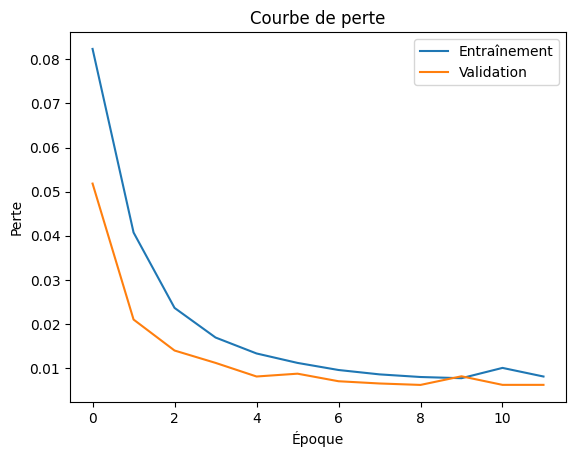

In [ ]:
history = autoencoder.history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

In [ ]:
reconstructed = autoencoder.predict(test)
erreurs_reconstruction = np.mean(np.square(test - reconstructed), axis=(1, 2, 3))
print(erreurs_reconstruction)

1/1 [==============================] - 2s 2s/step
[0.00363613 0.00128558 0.00556306 0.00228258 0.00682226 0.00155887
 0.00395827 0.00459624 0.0041764  0.00351534]


In [ ]:
print(min(erreurs_reconstruction)) #pour voir le point de départ du seuil
print(max(erreurs_reconstruction))

0.0012855808
0.00682226


In [ ]:
seuil= 0.003

In [ ]:
size= (350, 350)  #Charger l'image et l'afficher
img_path = '/content/normal-female-pelvis-mri-retroverted-uterus (4).jpg'
img_test = cv2.imread(img_path)
img_norm = img_test.astype(np.float32) #normalisation
img_norm /= 255.0
resized_img = cv2.resize(img_norm, size)
plt.imshow(resized_img, cmap='gray')
plt.show()

In [ ]:
tensor = tf.convert_to_tensor(resized_img) #conversion de l'image en tenseur
tensor = tf.expand_dims(tensor, axis=0) #le tenseur doit etre en 4D
print(tensor.shape)

(1, 350, 350, 3)


1/1 [==============================] - 0s 173ms/step


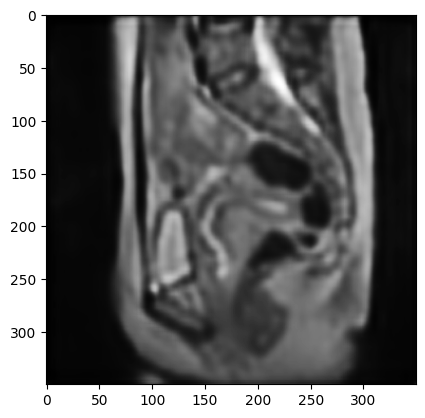

In [ ]:
reconstruction = autoencoder.predict(tensor)
generated_img = np.squeeze(reconstruction)  # Si nécessaire, supprimez les dimensions superflues
generated_img = generated_img * 255
generated_img = generated_img.astype(np.uint8)
import matplotlib.pyplot as plt
plt.imshow(generated_img, cmap='gray')
plt.show()

In [ ]:
erreur_reconstruction = np.mean(np.square(tensor - reconstruction))
print(" l'erreur de reconstruction est égale à:", erreur_reconstruction)
if erreur_reconstruction > seuil:
    print('Patiente Saine')
else:
    print('Patiente Malade')

 l'erreur de reconstruction est égale à: 0.003837963
Patiente Saine
